In [70]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Handling missing values
from sklearn.impute import SimpleImputer

# Machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer


# Model evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Feature selection
from sklearn.feature_selection import SelectFromModel

# For handling class imbalance
from imblearn.over_sampling import SMOTE

# For logging and tracking
import logging

# For saving and loading models
import joblib

# For warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
telecom_churn_data = pd.read_csv('telecom_churn_data.csv')
telecom_churn_data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [8]:
# Display basic information about the dataset
telecom_churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [10]:
# Convert date columns to datetime format
date_columns = ['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9']
telecom_churn_data[date_columns] = telecom_churn_data[date_columns].apply(pd.to_datetime, errors='coerce')

# Checking for missing values
missing_values_summary = telecom_churn_data.isnull().sum().sort_values(ascending=False)

# Displaying the summary of missing values for columns with missing data
missing_values_summary[missing_values_summary > 0]

arpu_3g_6               74846
night_pck_user_6        74846
total_rech_data_6       74846
arpu_2g_6               74846
max_rech_data_6         74846
                        ...  
last_date_of_month_8     1100
loc_ic_t2o_mou           1018
std_og_t2o_mou           1018
loc_og_t2o_mou           1018
last_date_of_month_7      601
Length: 166, dtype: int64

In [14]:
telecom_churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: datetime64[ns](4), float64(179), int64(35), object(8)
memory usage: 172.4+ MB


In [18]:
# Drop columns with more than 70% missing values
missing_values_summary = telecom_churn_data.isnull().sum().sort_values(ascending=False)
threshold = 0.7 * len(telecom_churn_data)
columns_to_drop = missing_values_summary[missing_values_summary > threshold].index
telecom_churn_data_cleaned = telecom_churn_data.drop(columns=columns_to_drop)

# Select only numeric columns for median imputation
numeric_columns = telecom_churn_data_cleaned.select_dtypes(include=['float64', 'int64']).columns
telecom_churn_data_cleaned[numeric_columns] = telecom_churn_data_cleaned[numeric_columns].fillna(telecom_churn_data_cleaned[numeric_columns].median())

# Verify if the missing values have been handled
missing_values_after_imputation = telecom_churn_data_cleaned.isnull().sum().sort_values(ascending=False)

# Display columns with remaining missing values
missing_values_after_imputation[missing_values_after_imputation > 0]

date_of_last_rech_9     4760
date_of_last_rech_8     3622
date_of_last_rech_7     1767
last_date_of_month_9    1659
date_of_last_rech_6     1607
last_date_of_month_8    1100
last_date_of_month_7     601
dtype: int64

In [20]:
# Create flag columns for missing dates
date_columns = ['date_of_last_rech_9', 'date_of_last_rech_8', 'date_of_last_rech_7', 'date_of_last_rech_6', 
                'last_date_of_month_9', 'last_date_of_month_8', 'last_date_of_month_7']

for col in date_columns:
    # Create flag columns to indicate if the value was missing
    telecom_churn_data[f'{col}_missing'] = telecom_churn_data[col].isnull().astype(int)

# Apply forward fill to the date columns
telecom_churn_data[date_columns] = telecom_churn_data[date_columns].fillna(method='ffill')

# Verify if the missing values have been imputed
missing_values_after_imputation_dates = telecom_churn_data[date_columns].isnull().sum()

# Display the count of remaining missing values in date columns
missing_values_after_imputation_dates

date_of_last_rech_9     0
date_of_last_rech_8     0
date_of_last_rech_7     0
date_of_last_rech_6     0
last_date_of_month_9    0
last_date_of_month_8    0
last_date_of_month_7    0
dtype: int64

In [24]:
# Define recharge columns for June and July
recharge_columns = ['total_rech_amt_6', 'total_rech_amt_7']

# Calculate the average recharge amount for June and July
avg_recharge = telecom_churn_data_cleaned[recharge_columns].mean(axis=1)

# Find the 70th percentile of the average recharge amount
recharge_70th_percentile = avg_recharge.quantile(0.7)

# Filter customers who are high value based on the 70th percentile threshold
high_value_customers = telecom_churn_data_cleaned[avg_recharge >= recharge_70th_percentile]

# Display the shape of the high-value customer dataset
print(f"High-value customers dataset shape: {high_value_customers.shape}")

# Preview the filtered data
high_value_customers.head()

High-value customers dataset shape: (30011, 193)


,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,date_of_last_rech_9_missing,date_of_last_rech_8_missing,date_of_last_rech_7_missing,date_of_last_rech_6_missing,last_date_of_month_9_missing,last_date_of_month_8_missing,last_date_of_month_7_missing
7,7000701601,109,0.0,0.0,0.0,2014-06-30,2014-07-31,2014-08-31,2014-09-30,1069.180,...,19.38,18.74,0.0,0,0,0,0,0,0,0
8,7001524846,109,0.0,0.0,0.0,2014-06-30,2014-07-31,2014-08-31,2014-09-30,378.721,...,910.65,122.16,0.0,0,0,0,0,0,0,0
13,7002191713,109,0.0,0.0,0.0,2014-06-30,2014-07-31,2014-08-31,2014-09-30,492.846,...,0.00,0.00,0.0,0,0,0,0,0,0,0
16,7000875565,109,0.0,0.0,0.0,2014-06-30,2014-07-31,2014-08-31,2014-09-30,430.975,...,2.45,21.89,0.0,0,0,0,0,0,0,0
17,7000187447,109,0.0,0.0,0.0,2014-06-30,2014-07-31,2014-08-31,2014-09-30,690.008,...,0.00,0.00,0.0,0,0,0,0,0,0,0


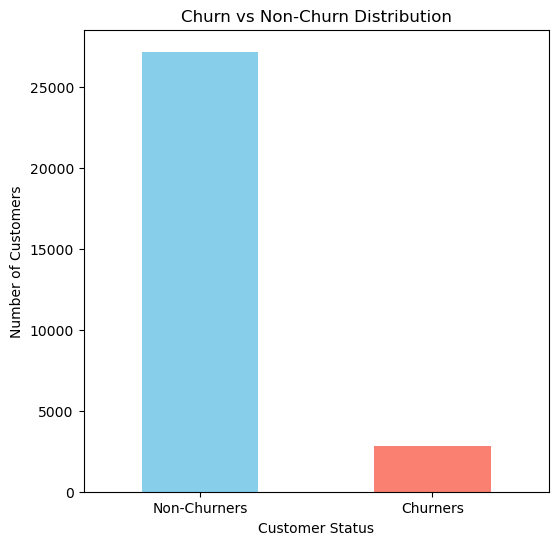

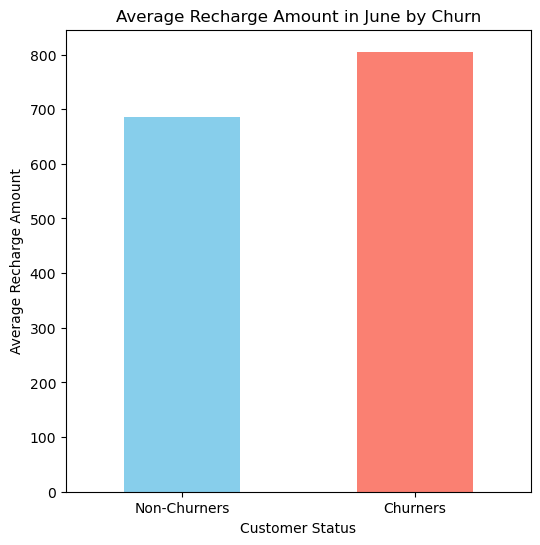

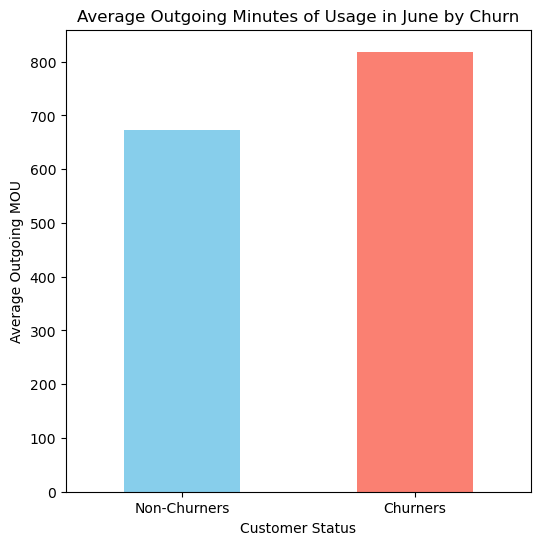

In [26]:
# Add churn label based on some assumed churn condition
# Here we assume a simple rule for demonstration (you can refine this based on the actual condition used previously)
high_value_customers['churn'] = high_value_customers['total_og_mou_9'] + high_value_customers['total_ic_mou_9'] == 0

# Churn distribution plot
plt.figure(figsize=(6, 6))
high_value_customers['churn'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Churn vs Non-Churn Distribution')
plt.xticks([0, 1], labels=['Non-Churners', 'Churners'], rotation=0)
plt.ylabel('Number of Customers')
plt.xlabel('Customer Status')
plt.show()

# Average recharge amount for churners and non-churners
plt.figure(figsize=(6, 6))
high_value_customers.groupby('churn')['total_rech_amt_6'].mean().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Average Recharge Amount in June by Churn')
plt.xticks([0, 1], labels=['Non-Churners', 'Churners'], rotation=0)
plt.ylabel('Average Recharge Amount')
plt.xlabel('Customer Status')
plt.show()

# Average outgoing minutes of usage for churners and non-churners
plt.figure(figsize=(6, 6))
high_value_customers.groupby('churn')['total_og_mou_6'].mean().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Average Outgoing Minutes of Usage in June by Churn')
plt.xticks([0, 1], labels=['Non-Churners', 'Churners'], rotation=0)
plt.ylabel('Average Outgoing MOU')
plt.xlabel('Customer Status')
plt.show()

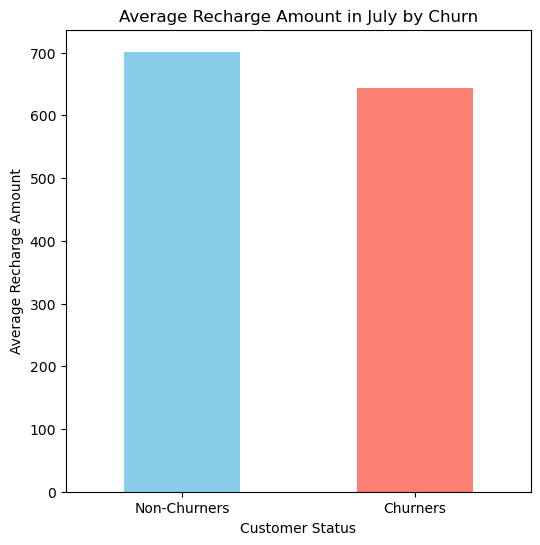

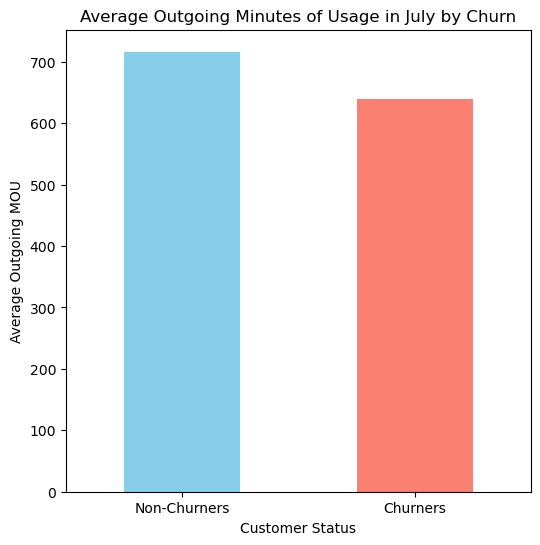

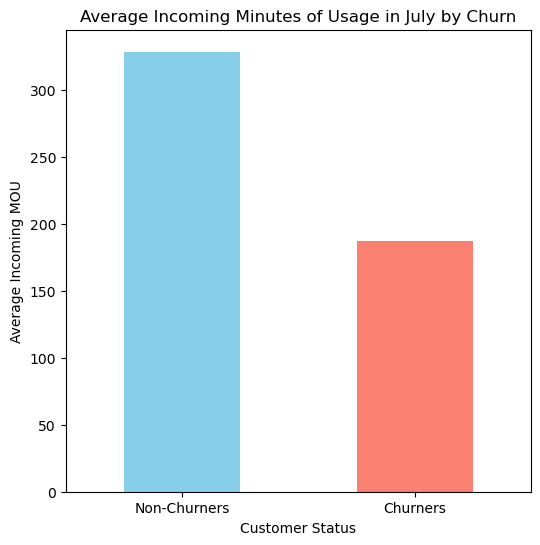

In [28]:
# Visualizations for the month of July

# Average recharge amount in July by churn
plt.figure(figsize=(6, 6))
high_value_customers.groupby('churn')['total_rech_amt_7'].mean().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Average Recharge Amount in July by Churn')
plt.xticks([0, 1], labels=['Non-Churners', 'Churners'], rotation=0)
plt.ylabel('Average Recharge Amount')
plt.xlabel('Customer Status')
plt.show()

# Average outgoing minutes of usage in July by churn
plt.figure(figsize=(6, 6))
high_value_customers.groupby('churn')['total_og_mou_7'].mean().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Average Outgoing Minutes of Usage in July by Churn')
plt.xticks([0, 1], labels=['Non-Churners', 'Churners'], rotation=0)
plt.ylabel('Average Outgoing MOU')
plt.xlabel('Customer Status')
plt.show()

# Average incoming minutes of usage in July by churn
plt.figure(figsize=(6, 6))
high_value_customers.groupby('churn')['total_ic_mou_7'].mean().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Average Incoming Minutes of Usage in July by Churn')
plt.xticks([0, 1], labels=['Non-Churners', 'Churners'], rotation=0)
plt.ylabel('Average Incoming MOU')
plt.xlabel('Customer Status')
plt.show()

In [34]:
# Tagging churners based on the churn condition:
# Customers who have no incoming calls (total_ic_mou_9), no outgoing calls (total_og_mou_9), and no mobile internet usage (vol_2g_mb_9, vol_3g_mb_9) in September (month 9).

churn_condition = (
    (high_value_customers['total_ic_mou_9'] == 0) &
    (high_value_customers['total_og_mou_9'] == 0) &
    (high_value_customers['vol_2g_mb_9'] == 0) &
    (high_value_customers['vol_3g_mb_9'] == 0)
)

# Tagging churners (1 = churner, 0 = non-churner)
high_value_customers['churn'] = churn_condition.astype(int)

# Now, remove all columns related to the churn phase (i.e., columns with '_9')
churn_phase_columns = [col for col in high_value_customers.columns if '_9' in col]
high_value_customers_cleaned = high_value_customers.drop(columns=churn_phase_columns)

# Checking the updated shape of the data after removing churn-phase columns
high_value_customers_cleaned.shape

(30011, 148)

In [40]:
# Impute missing values with the median (you can also use 'mean' or another strategy)
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Drop rows with missing values
X_train = X_train.dropna()
y_train = y_train[X_train.index]
X_test = X_test.dropna()
y_test = y_test[X_test.index]

In [48]:
churn_condition = (
    (telecom_churn_data['total_ic_mou_9'] == 0) &
    (telecom_churn_data['total_og_mou_9'] == 0) &
    (telecom_churn_data['vol_2g_mb_9'] == 0) &
    (telecom_churn_data['vol_3g_mb_9'] == 0)
)
telecom_churn_data['churn'] = churn_condition.astype(int)

# Removing columns with '_9'
churn_phase_columns = [col for col in telecom_churn_data.columns if '_9' in col]
high_value_customers_cleaned = telecom_churn_data.drop(columns=churn_phase_columns)

# Splitting the data into features (X) and target (y)
X = high_value_customers_cleaned.drop(columns=['churn'])
y = high_value_customers_cleaned['churn']

# Select only numeric columns from X
X_numeric = X.select_dtypes(include=['float64', 'int64'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.3, random_state=42, stratify=y)

# Impute missing values with the median for the training and test sets
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Build the logistic regression model with class weight adjustment to handle class imbalance
logreg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
logreg.fit(X_train_scaled, y_train)

# Make predictions and evaluate the model
y_pred = logreg.predict(X_test_scaled)
classification_report_output = classification_report(y_test, y_pred)
confusion_matrix_output = confusion_matrix(y_test, y_pred)

print(classification_report_output, confusion_matrix_output)

              precision    recall  f1-score   support

           0       0.98      0.85      0.91     26943
           1       0.39      0.83      0.53      3057

    accuracy                           0.85     30000
   macro avg       0.68      0.84      0.72     30000
weighted avg       0.92      0.85      0.87     30000
 [[22991  3952]
 [  515  2542]]


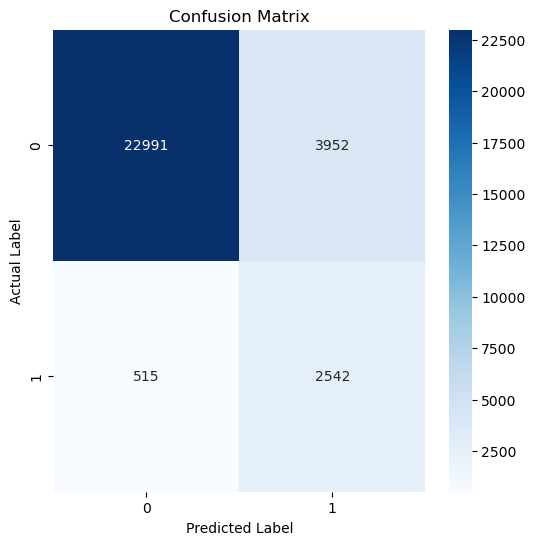

In [78]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

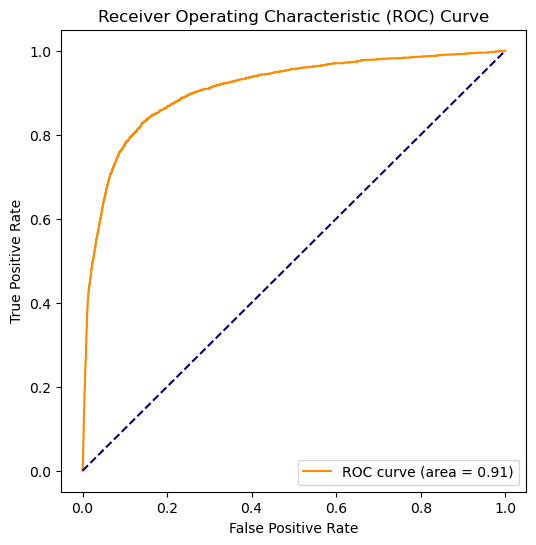

In [52]:
# Compute predicted probabilities
y_pred_proba = logreg.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

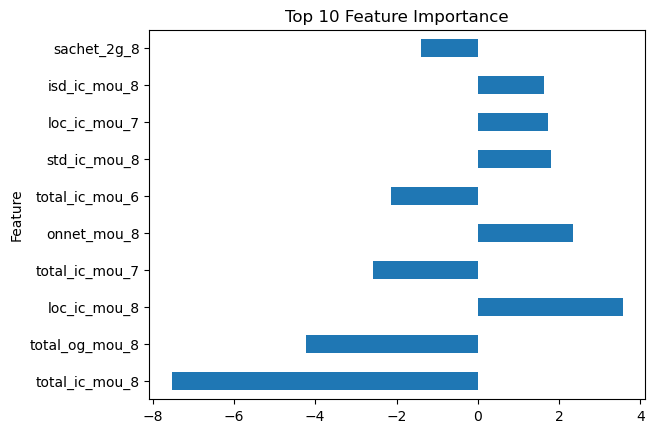

In [54]:
# Get feature names and logistic regression coefficients
feature_names = X_numeric.columns
coefficients = logreg.coef_.flatten()

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the features by importance (absolute value of the coefficient)
feature_importance_df['Absolute_Coefficient'] = np.abs(feature_importance_df['Coefficient'])
feature_importance_df = feature_importance_df.sort_values(by='Absolute_Coefficient', ascending=False)

# Plot the top 10 most important features
feature_importance_df.head(10).plot(kind='barh', x='Feature', y='Coefficient', title='Top 10 Feature Importance', legend=False)
plt.show()

In [56]:
# Define the parameter grid for C
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# Perform grid search
grid_search = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42), param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best AUC Score:", grid_search.best_score_)

Best Parameters: {'C': 10}
Best AUC Score: 0.9121434842551028


In [58]:
# Apply SMOTE to balance the class distribution
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_imputed, y_train)

# Proceed with scaling and training the model as before
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
logreg.fit(X_train_smote_scaled, y_train_smote)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [62]:
# Define logistic regression model
logreg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

# Perform 5-fold cross-validation and evaluate the model using ROC-AUC
cv_scores = cross_val_score(logreg, X_train_scaled, y_train, cv=5, scoring='roc_auc')

# Output the cross-validation scores
print("Cross-Validation AUC Scores:", cv_scores)
print("Mean AUC Score:", cv_scores.mean())

Cross-Validation AUC Scores: [0.91170694 0.91128201 0.90881462 0.91776992 0.91099586]
Mean AUC Score: 0.9121138711206068


In [64]:
# Define parameter grid for logistic regression (tuning the regularization parameter C)
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
                           param_grid, cv=5, scoring='roc_auc')

# Fit the grid search
grid_search.fit(X_train_scaled, y_train)

# Output the best parameters and the best cross-validation score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation AUC Score:", grid_search.best_score_)

Best Parameters: {'C': 10}
Best Cross-Validation AUC Score: 0.9121434842551028


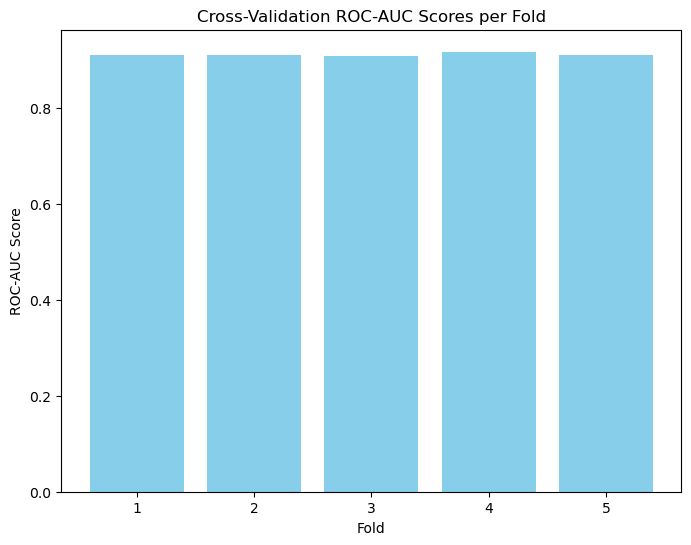

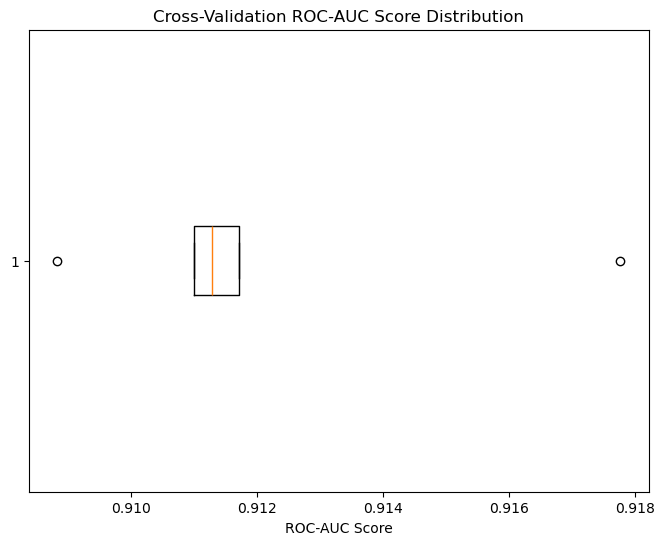

Mean Cross-Validation AUC Score: 0.9121138711206068


In [68]:
# Perform 5-fold cross-validation and evaluate the model using ROC-AUC
cv_scores = cross_val_score(logreg, X_train_scaled, y_train, cv=5, scoring='roc_auc')

# Bar Plot for Cross-Validation Scores
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(cv_scores) + 1), cv_scores, color='skyblue')
plt.xlabel('Fold')
plt.ylabel('ROC-AUC Score')
plt.title('Cross-Validation ROC-AUC Scores per Fold')
plt.show()

# Box Plot for Cross-Validation Scores
plt.figure(figsize=(8, 6))
plt.boxplot(cv_scores, vert=False)
plt.xlabel('ROC-AUC Score')
plt.title('Cross-Validation ROC-AUC Score Distribution')
plt.show()

# Print Mean Cross-Validation AUC Score
print("Mean Cross-Validation AUC Score:", cv_scores.mean())

In [84]:

# Create a PDF file path
pdf_path = 'C:/Users/shail/OneDrive/Desktop/final_telecom_churn_analysis_visualizations.pdf'

with PdfPages(pdf_path) as pdf:
    # 1. Churn Distribution Plot
    plt.figure(figsize=(6, 6))
    high_value_customers['churn'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title('Churn vs Non-Churn Distribution')
    plt.xticks([0, 1], labels=['Non-Churners', 'Churners'], rotation=0)
    plt.ylabel('Number of Customers')
    plt.xlabel('Customer Status')
    pdf.savefig()
    plt.close()
 
    # 2. Average recharge amount for churners and non-churners
    plt.figure(figsize=(6, 6))
    high_value_customers.groupby('churn')['total_rech_amt_6'].mean().plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title('Average Recharge Amount in June by Churn')
    plt.xticks([0, 1], labels=['Non-Churners', 'Churners'], rotation=0)
    plt.ylabel('Average Recharge Amount')
    plt.xlabel('Customer Status')
    pdf.savefig()
    plt.close()

    # 3. Average outgoing minutes of usage for churners and non-churners
    plt.figure(figsize=(6, 6))
    high_value_customers.groupby('churn')['total_og_mou_6'].mean().plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title('Average Outgoing Minutes of Usage in June by Churn')
    plt.xticks([0, 1], labels=['Non-Churners', 'Churners'], rotation=0)
    plt.ylabel('Average Outgoing MOU')
    plt.xlabel('Customer Status')
    pdf.savefig()
    plt.close()

    # 4. Average recharge amount in July by churn
    plt.figure(figsize=(6, 6))
    high_value_customers.groupby('churn')['total_rech_amt_7'].mean().plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title('Average Recharge Amount in July by Churn')
    plt.xticks([0, 1], labels=['Non-Churners', 'Churners'], rotation=0)
    plt.ylabel('Average Recharge Amount')
    plt.xlabel('Customer Status')
    pdf.savefig()
    plt.close()

    # 5. Average outgoing minutes of usage in July by churn
    plt.figure(figsize=(6, 6))
    high_value_customers.groupby('churn')['total_og_mou_7'].mean().plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title('Average Outgoing Minutes of Usage in July by Churn')
    plt.xticks([0, 1], labels=['Non-Churners', 'Churners'], rotation=0)
    plt.ylabel('Average Outgoing MOU')
    plt.xlabel('Customer Status')
    pdf.savefig()
    plt.close()

    # 6. Average incoming minutes of usage in July by churn
    plt.figure(figsize=(6, 6))
    high_value_customers.groupby('churn')['total_ic_mou_7'].mean().plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title('Average Incoming Minutes of Usage in July by Churn')
    plt.xticks([0, 1], labels=['Non-Churners', 'Churners'], rotation=0)
    plt.ylabel('Average Incoming MOU')
    plt.xlabel('Customer Status')
    pdf.savefig()
    plt.close()

    # 7. Confusion Matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    pdf.savefig()
    plt.close()

    # 8. Plot ROC curve
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    pdf.savefig()
    plt.close()

    # 9. Feature Importance Plot (Top 10 Features)
    feature_importance_df.head(10).plot(kind='barh', x='Feature', y='Coefficient', title='Top 10 Feature Importance', legend=False)
    plt.tight_layout()
    pdf.savefig()
    plt.close()

    # 10. Cross-Validation Scores Plot
    plt.figure(figsize=(8, 6))
    plt.bar(range(1, len(cv_scores) + 1), cv_scores, color='skyblue')
    plt.xlabel('Fold')
    plt.ylabel('ROC-AUC Score')
    plt.title('Cross-Validation ROC-AUC Scores per Fold')
    pdf.savefig()
    plt.close()

    # 11. Box Plot for Cross-Validation Scores
    plt.figure(figsize=(8, 6))
    plt.boxplot(cv_scores, vert=False)
    plt.xlabel('ROC-AUC Score')
    plt.title('Cross-Validation ROC-AUC Score Distribution')
    pdf.savefig()
    plt.close()

# Provide the file path for download
pdf_path

'C:/Users/shail/OneDrive/Desktop/final_telecom_churn_analysis_visualizations.pdf'